In [ ]:
import pandas as pd
import numpy as np

In [ ]:

sheet_url='https://docs.google.com/spreadsheets/d/1MvIxVRBs4u6UFfvnu2khnU_gtrcoLUch5Tci-hcdkAk/edit#gid=635530870'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

df = pd.read_csv(csv_export_url)
df

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,AND 1 = utl_inaddr.get_host_address ( ( SE...,1
4,select * from users where id = '1' or @ @1 = ...,1
...,...,...
37938,"org/?option = com_k2 <a href = ""http://corfopym",0
37939,com/?option = com_k2 <act> <![CDATA[procMemb...,0
37940,picsearch,0
37941,com/is?-WZx-uhyLezKNiYLvAbKL3W4oh5F749nr2KUmFF...,0


In [ ]:
df.dtypes

Sentence    object
Label        int64
dtype: object

In [ ]:
sentence_col = df.drop(['Label'],axis='columns')
Y = df['Label']
sentence_col

,Sentence
0,""" or pg_sleep ( __TIME__ ) --"
1,create user name identified by pass123 tempora...
2,%29
3,AND 1 = utl_inaddr.get_host_address ( ( SE...
4,select * from users where id = '1' or @ @1 = ...
...,...
37938,"org/?option = com_k2 <a href = ""http://corfopym"
37939,com/?option = com_k2 <act> <![CDATA[procMemb...
37940,picsearch
37941,com/is?-WZx-uhyLezKNiYLvAbKL3W4oh5F749nr2KUmFF...


# Pre Processing

1) removed \n at the end of each line

2) replaced %20 by space #### Source: https://github.com/foospidy/payloads/tree/master/other/sqli

3) Removing rows if sentence column contains null values


In [ ]:
# preprocess sql data to have same format for all files

def clean_sqli_data(data):
    
    for i in range(len(data)):
        
        data[i]=data[i].replace('\n', '')
        data[i]=data[i].replace('%20', ' ')
        data[i]=data[i].replace('%21', ' ')
        data[i]=data[i].replace('=', ' = ')
        data[i]=data[i].replace('((', ' (( ')
        data[i]=data[i].replace('))', ' )) ')
        data[i]=data[i].replace('(', ' ( ')
        data[i]=data[i].replace(')', ' ) ')
    
    return data

In [ ]:

# removing the row if "Sentence" column contains null  value
df.dropna(subset = ["Sentence"], inplace=True)
# removing duplicate rows
df.drop_duplicates(inplace = True)

sql_lines=[]
labels=[]
# inserting dataframe data into list
for index, row in df.iterrows():
    sql_lines.append(row['Sentence'] )
    labels.append(row['Label'])
    #print(type(row['Sentence']))
    #print(row['Sentence'])


cleaned_data=clean_sqli_data(sql_lines)
cleaned_df = pd.DataFrame(list(zip(cleaned_data, labels)),columns =['Query', 'Label'])
cleaned_df

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,AND 1 = utl_inaddr.get_host_address ( ...,1
4,select * from users where id = '1' or @ @1 ...,1
...,...,...
33658,"Scipio, Milton called height Rome; history re...",0
33659,", 2008 )",0
33660,"For instance, English question sentences, end...",0
33661,The period word menu predicted parsing adverbi...,0


# **Feature Extraction**

In [ ]:
#  Detect select/update/insert/delete keyword at the initial part of the query

def isFetchCommandType(query):

    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'select' ):
        return 1
    else:
        return 0

def isUpdateCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'update' ):
        return 1
    else:
        return 0
      
def isInsertCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'insert' ):
        return 1
    else:
        return 0

def isDeleteCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'delete' ):
        return 1
    else:
        return 0


print(isFetchCommandType("INSERT into(223,'sajid','2343113')") )
print(isUpdateCommandType("DELETE into(223,'brishty','2343113')") )
print(isInsertCommandType("DELETE into(223,'sajid','2343113')") )
print(isDeleteCommandType("DELETE into(223,'brishty','2343113')") )

0
0
0
1


In [ ]:
# Detect 'order by' keyword in the query

def detectSortClause(query):
    keyword='order by'
    if(keyword in query.lower()):
        return 1
    else:
        return 0
    
print(detectSortClause("-5021'+ ( select yadq where 4285 = 4285 Order By 1#"))

1


In [ ]:
  # Detect group by keyword
  def detectGroupClause(query):
      keyword= 'group by'  
      if(keyword in query.lower()):
          return 1
      else:
          return 0

print(detectGroupClause("-5021'+ ( select yadq where 4285 = 4285 Group By 1#"))

1


In [ ]:
# Detect over keyword 

def detectWindowClause(query):
    keyword='over'
    if(keyword in query.lower()):
        return 1
    else:
        return 0

print(detectWindowClause("-5021'+ ( select yadq where 4285 = 4285 order by 1#"))

0


In [ ]:
#hasRecursive: Indicator if SQL is specified WITH RECURSIVE clause
def detectWithRecursive(query):
    keyword='with recursive'
    if(keyword in query.lower()):
        return 1
    else:
        return 0
print(detectWithRecursive('With Recursive parent_of(name, parent) AS (SELECT name, mom FROM family UNION SELECT name, dad FROM family);'))


1


In [ ]:
#hasDistinctOn: Indicator if distinct clause is from DISTINCT ON
def detecthasDistinctOn(query):
    keyword= 'distinct on'
    if(keyword in query.lower()):
        return 1
    else:
        return 0

print(detecthasDistinctOn('SELECT * FROM (SELECT DISTINCT ON(address_id) * FROM purchases WHERE product_id = 1 ORDER BY address_id, purchased_at DESC) t ORDER BY purchased_at DESC;'))
print(detecthasDistinctOn('SELECT * FROM First JOIN SELECT * FROM Second;')  )


1
0


In [ ]:
#utilityStmt: Indicator if the SQL is DECLARE CURSOR or a non-optimizable statement

def utilityStmt(query):
    keyword1='declare'
    keyword2='cursor'
    if(keyword1 in query.lower() and keyword2 in query.lower()):
      return 1
    else:
      return 0

print(utilityStmt('EXEC SQL DECLARE C3 CURSOR WITH HOLD FOR SELECT * FROM EMPLOYEE FOR UPDATE OF WORKDEPT, PHONENO, JOB, EDLEVEL, SALARY;'))
print(utilityStmt('SELECT * FROM First JOIN SELECT * FROM Second;')  )


1
0


operators list in this link: https://www.w3schools.com/sql/sql_operators.asp

In [ ]:
#jointree/quals/args*/boolop* : Qualification type BOOLEXPR, OPEXPR and boolean operation and, or, not

def hasLogicalOperator(query):
      keywords=['and','or','not','all','any','between','exists','in','like','some']
      for key in keywords:
        if(key in query.lower()):
          return 1
        else:
          return 0

print(hasLogicalOperator('SELECT column-names FROM table-name WHERE condition1 AND condition2;'))
print(hasLogicalOperator('UPDATE table-name SET column-name = value WHERE condition1 OR condition2;'))
print(hasLogicalOperator('DELETE table-name WHERE NOT condition;'))

1
0
0


In [ ]:


def hasArithmaticOperator(query):
    keywords=['+','-','*','/','%']
   
    for key in keywords:
        if(key in query):
            return 1
        
    return 0


print(hasArithmaticOperator("SELECT city, SUM(order_amount) total_order_amount FROM sum GROUP BY city"))

0


In [ ]:

def hasComparisonOperator(query):
    keywords=['=','>','<','>=','<=','<>']
    
    for key in keywords:
        if(key in query):
            return 1
        
    return 0

print(hasComparisonOperator('SELECT * FROM Products WHERE Price = 18;' ) )

1


In [ ]:

def hasCompoundOperator(query):
    keywords=['+=','-=',"*=",'/=','%=','&=','^-=','|*=']
   
    for key in keywords:
        if(key in query):
            return 1
    return 0


print(hasCompoundOperator('SELECT * FROM Products WHERE Price = 18;' ))

0


**List of window functions**: https://www.sqlshack.com/use-window-functions-sql-server/

In [ ]:
# detect window function in the query RANK(), DENSE_RANK(), ROW_NUMBER(), NTILE(),SUM(), MAX(), MIN(), AVG(). COUNT(),LAG(), LEAD(), FIRST_VALUE(), LAST_VALUE(),
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def hasWindowFunc(query):
    window_func_list=['sum','avg','max','min','count','rank','dense_rank','row_number','nitle','lag','lead','first_value','last_value']
    tokenized_list = word_tokenize(query.lower())
   
    #print(tokenized_list)
    for window_func in window_func_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(window_func == tokenized_list[i]):
                if(i+1 < len(tokenized_list)):
                      if( tokenized_list[i+1] == '('):
                          return 1
                      else:
                          return 0
    return 0



hasWindowFunc("SELECT city, SUM(order_amount) total_order_amount FROM sum GROUP BY city")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1

In [ ]:
# hasAggs: Indicator if SQL has aggregates (sum(),avg(),max(),min(),count())
def hasAggs(query):
    Agg_func_list=['sum','avg','max','min','count']
    tokenized_list = word_tokenize(query.lower())
    
    #print(tokenized_list)
    for Agg_func in Agg_func_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(Agg_func == tokenized_list[i]):
                if( tokenized_list[i+1] == '('):
                    return 1
                else:
                    return 0
    return 0

    
print(hasAggs("-5021'+ avg( select yadq where 4285 = 4285 order by 1#"))
print(utilityStmt('SELECT * FROM First JOIN SELECT * FROM Second;')  )
print(hasAggs("-5021'+ max( select yadq where 4285 = 4285 order by 1#"))
print(hasAggs("-5021'+ min( select yadq where 4285 = 4285 order by 1#"))
print(hasAggs("-5021'+ count( select yadq where 4285 = 4285 order by 1#"))

1
0
1
1
1


In [ ]:
#detect set operations like union,union all, except, intersect

def hasSetOperation(query):
    set_list=['union','union all','except','intersect']
    tokenized_list = word_tokenize(query.lower())
   
    #print(tokenized_list)
    for set_op in set_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(set_op in tokenized_list):
                return 1
            
    return 0

print(hasSetOperation('SELECT * FROM First JOIN SELECT * FROM Second;'))

0


In [ ]:
#cteList---> getNumberOfWithClause() 
# detect number of with clasue 

def getNumberOfWithClause(query) :
    keyword='with'
    
    tokenized_list = word_tokenize(query.lower())
    print(tokenized_list)
    cnt=0
    for word in tokenized_list:
        if(keyword == word ):
            cnt +=1
    
    return cnt    




print(getNumberOfWithClause( ' WITH totalSalary(Airline, total) as (SELECT Airline, sum(Salary) FROM Pilot GROUP BY Airline),airlineAverage(avgSalary) as (SELECT avg(Salary) FROM Pilot )  SELECT Airline FROM totalSalary, airlineAverage WHERE totalSalary.total >= airlineAverage.avgSalary;'))

['with', 'totalsalary', '(', 'airline', ',', 'total', ')', 'as', '(', 'select', 'airline', ',', 'sum', '(', 'salary', ')', 'from', 'pilot', 'group', 'by', 'airline', ')', ',', 'airlineaverage', '(', 'avgsalary', ')', 'as', '(', 'select', 'avg', '(', 'salary', ')', 'from', 'pilot', ')', 'select', 'airline', 'from', 'totalsalary', ',', 'airlineaverage', 'where', 'totalsalary.total', '>', '=', 'airlineaverage.avgsalary', ';']
1


In [ ]:
# detect sub query in the query

def detectSubQuery(query):
    commands = ['select','update','insert','delete']
    tokenized_list = word_tokenize(query.lower())
    cnt=0
    for command in commands:
        if(command in tokenized_list):
            cnt+=1
    if(cnt>1):
        return 1
    else:
        return 0


print(detectSubQuery('UPDATE CUSTOMERS SET SALARY = SALARY * 0.25 WHERE AGE IN ( SELECT AGE FROM CUSTOMERS_BKP WHERE AGE >= 27 );'))

print( detectSubQuery('INSERT INTO CUSTOMERS_BKP SELECT * FROM CUSTOMERS WHERE ID IN (SELECT ID FROM CUSTOMERS) ;') )

1
1


In [ ]:
# detect string constant type 


def hasStringConstnt(query):
    ck=0
    new_query=query.lower()
    
    for i in range(len(new_query)):
        
        if(new_query[i] == '\''):
            ck=1
            break
            
    if(ck==1 ):
        return 1
    else:
        return 0

print(hasStringConstnt("SELECT * FROM Customers WHERE Country='Mexico' and city='\t';") )

1


Constants:  https://ecomputernotes.com/what-is-c/types-and-variables/what-is-constants-type-of-constant

In [ ]:
# detect backslash character constants

def hasEscapeSeq(query):
    escape_chars=['\a','/*','#',';'
                  '\b',
                  '\f',
                  '\n',
                  '\r',
                  '\t',
                  '\v',
                  '\'',
                  "\''",
                  '\?',
                  '\\',
                  '\0']
    for chars in escape_chars:
        if(chars in  query.lower()):
            return 1
        
    return 0    


print(hasEscapeSeq("SELECT * FROM Customers WHERE Country='Mexico' and city='';") )


1


In [ ]:
# detect numbers in query
from sklearn.feature_extraction.text import CountVectorizer

def detectNumber(query):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([query])
    print(vectorizer.get_feature_names())
    tokenized_list=vectorizer.get_feature_names()
    for word in tokenized_list:
        ck=0
        try:
          num = int(word)
          ck=1 
        except:
          try:
            num = float(word)
            ck=2
          except:
            ck=3
        if(ck == 1 or ck == 2):
          return 1 #number
        else:
          return 0 #non-number
        
      
    


print(detectNumber("SELECT * FROM Customers WHERE AGE==20 "))

['20', 'age', 'customers', 'from', 'select', 'where']
1


In [ ]:
def detectDropKeyword(query):
        keyword='drop'
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        for word in tokenized_list:
            if(word==keyword):
                return 1
        return 0

print(detectDropKeyword("SELECT * FROM Customers WHERE AGE==20 ;drop table users;"))
print(detectDropKeyword("SELECT * FROM Customers WHERE AGE==20 ;"))

['20', 'age', 'customers', 'drop', 'from', 'select', 'table', 'users', 'where']
1
['20', 'age', 'customers', 'from', 'select', 'where']
0


In [ ]:


def detectStoredProcedure(query):
        user_defined_keywords=['create','procedure','call']
        builtin_func_keywords=['sleep','pg_sleep','shutdown']
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        found=[]
        for word in tokenized_list:
            if(word in user_defined_keywords):
                if(word not in found):
                    found.append(word)
        # if it is not user defined stored procedure ,then go for built in procedure
        if(len(found)==len(user_defined_keywords)):
            return 1
        else:
            for word in tokenized_list:
                if(word in builtin_func_keywords):
                    return 1
            
            return 0
      

print(detectStoredProcedure("CREATE PROCEDURE SelectAllCustomers() LANGUAGE SQL as $$ delete from Users where username = 'shourav';$$; CALL SelectAllCustomers(); select * from users where username='sajid ' "))

['as', 'call', 'create', 'delete', 'from', 'language', 'procedure', 'sajid', 'select', 'selectallcustomers', 'shourav', 'sql', 'username', 'users', 'where']
1


# Encapsulation of feature extraction functions inside a class

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


class SqlFeatureExtraction:

    def __init__(self):
        print("SQL feature extraction object created")
    
    
    # it returns a feature vector for a particular SQL query
    def extractFeatures(self,query):
        features=[]
        features.append( self.isFetchCommandType(query) )
        features.append( self.isUpdateCommandType(query) )
        features.append( self.isInsertCommandType(query) )
        features.append( self.isDeleteCommandType(query) )
        features.append( self.detectSortClause(query) )
        features.append( self.detectGroupClause(query) )
        features.append( self.detectWindowClause(query) )
        features.append( self.detectWithRecursive(query) )
        features.append( self.detecthasDistinctOn(query) )
        features.append( self.utilityStmt(query) )
        features.append(self.hasLogicalOperator(query) )
        features.append( self.hasArithmaticOperator(query)  )
        features.append( self.hasComparisonOperator(query)  )
        features.append( self.hasCompoundOperator(query) )
        features.append( self.hasWindowFunc(query) )
        features.append( self.hasAggs(query)  )
        features.append( self.hasSetOperation(query) )  
        features.append( self.getNumberOfWithClause(query))
        features.append( self.detectSubQuery(query) )
        features.append( self.hasStringConstnt(query) )
        features.append( self.hasEscapeSeq(query) )
        features.append( self.detectNumber(query) )
        features.append( self.detectDropKeyword(query) )
        features.append( self.detectStoredProcedure(query) )
        return features
    
    #  Detect select/update/insert/delete keyword at the initial part of the query
    # f1
    def isFetchCommandType(self,query):

        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'select' ):
            return 1
        else:
            return 0

    #f2
    def isUpdateCommandType(self,query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'update' ):
            return 1
        else:
            return 0
    #f3   
    def isInsertCommandType(self,query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'insert' ):
            return 1
        else:
            return 0
    #f4
    def isDeleteCommandType(self,query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'delete' ):
            return 1
        else:
            return 0


    # Detect 'order by' keyword in the query
    #f5
    def detectSortClause(self,query):
        keyword='order by'
        if(keyword in query.lower()):
            return 1
        else:
            return 0

    # Detect group by keyword
    def detectGroupClause(self,query):
          keyword= 'group by'  
          if(keyword in query.lower()):
              return 1
          else:
              return 0


    # Detect over keyword 

    def detectWindowClause(self,query):
        keyword='over'
        if(keyword in query.lower()):
            return 1
        else:
            return 0


    #hasRecursive: Indicator if SQL is specified WITH RECURSIVE clause
    def detectWithRecursive(self,query):
        keyword='with recursive'
        if(keyword in query.lower()):
            return 1
        else:
            return 0


    #hasDistinctOn: Indicator if distinct clause is from DISTINCT ON
    def detecthasDistinctOn(self,query):
        keyword= 'distinct on'
        if(keyword in query.lower()):
            return 1
        else:
            return 0

    #utilityStmt: Indicator if the SQL is DECLARE CURSOR or a non-optimizable statement

    def utilityStmt(self,query):
        keyword1='declare'
        keyword2='cursor'
        if(keyword1 in query.lower() and keyword2 in query.lower()):
          return 1
        else:
          return 0

    #jointree/quals/args*/boolop* : Qualification type BOOLEXPR, OPEXPR and boolean operation and, or, not

    def hasLogicalOperator(self,query):
          keywords=['and','or','not','all','any','between','exists','in','like','some']
          for key in keywords:
            if(key in query.lower()):
              return 1
            else:
              return 0

    def hasArithmaticOperator(self,query):
        keywords=['+','-','*','/','%']
      
        for key in keywords:
            if(key in query):
                return 1
            
        return 0

    def hasComparisonOperator(self,query):
        keywords=['=','>','<','>=','<=','<>']
        
        for key in keywords:
            if(key in query):
                return 1
            
        return 0


    def hasCompoundOperator(self,query):
        keywords=['+=','-=',"*=",'/=','%=','&=','^-=','|*=']
      
        for key in keywords:
            if(key in query):
                return 1
        return 0



    # detect window function in the query RANK(), DENSE_RANK(), ROW_NUMBER(), NTILE(),SUM(), MAX(), MIN(), AVG(). COUNT(),LAG(), LEAD(), FIRST_VALUE(), LAST_VALUE(),


    def hasWindowFunc(self,query):
        window_func_list=['sum','avg','max','min','count','rank','dense_rank','row_number','nitle','lag','lead','first_value','last_value']
        tokenized_list = word_tokenize(query.lower())
      
        #print(tokenized_list)
        for window_func in window_func_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(window_func == tokenized_list[i]):
                    if(i+1 < len(tokenized_list)):
                        if( tokenized_list[i+1] == '('):
                            return 1
                        else:
                            return 0
        return 0


    # hasAggs: Indicator if SQL has aggregates (sum(),avg(),max(),min(),count())
    def hasAggs(self,query):
        Agg_func_list=['sum','avg','max','min','count']
        tokenized_list = word_tokenize(query.lower())
        
        #print(tokenized_list)
        for Agg_func in Agg_func_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(Agg_func == tokenized_list[i]):
                    if( tokenized_list[i+1] == '('):
                        return 1
                    else:
                        return 0
        return 0


    #detect set operations like union,union all, except, intersect

    def hasSetOperation(self,query):
        set_list=['union','union all','except','intersect']
        tokenized_list = word_tokenize(query.lower())
      
        #print(tokenized_list)
        for set_op in set_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(set_op in tokenized_list):
                    return 1
                
        return 0


    #cteList---> getNumberOfWithClause() 
    # detect number of with clasue 

    def getNumberOfWithClause(self,query) :
        keyword='with'
        
        tokenized_list = word_tokenize(query.lower())
        #print(tokenized_list)
        cnt=0
        for word in tokenized_list:
            if(keyword == word ):
                cnt +=1
        
        return cnt



    # detect sub query in the query

    def detectSubQuery(self,query):
        commands = ['select','update','insert','delete']
        tokenized_list = word_tokenize(query.lower())
        cnt=0
        for command in commands:
            if(command in tokenized_list):
                cnt+=1
        if(cnt>1):
            return 1
        else:
            return 0


    # detect string constant type 

    def hasStringConstnt(self,query):
        ck=0
        new_query=query.lower()
        
        for i in range(len(new_query)):
            
            if(new_query[i] == '\''):
                ck=1
                break
                
        if(ck==1 ):
            return 1
        else:
            return 0



    # detect backslash character constants

    def hasEscapeSeq(self,query):
        escape_chars=['\a','/*','#',
                      '\b',
                      '\f',
                      '\n',
                      '\r',
                      '\t',
                      '\v',
                      '\'',
                      "\''",
                      '\?',
                      '\\',
                      '\0',
                      ';']
        for chars in escape_chars:
            if(chars in  query.lower()):
                return 1
            
        return 0    


    # detect numbers in query


    def detectNumber(self,query):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        #print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        for word in tokenized_list:
            ck=0
            try:
              num = int(word)
              ck=1 
            except:
              try:
                num = float(word)
                ck=2
              except:
                ck=3
            if(ck == 1 or ck == 2):
              return 1 #number
            else:
              return 0 #non-number
            
    def detectDropKeyword(self,query):
        keyword='drop'
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        for word in tokenized_list:
            if(word==keyword):
                return 1
        return 0


    def detectStoredProcedure(self,query):
        user_defined_keywords=['create','procedure','call']
        builtin_func_keywords=['sleep','pg_sleep','shutdown']
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        found=[]
        for word in tokenized_list:
            if(word in user_defined_keywords):
                if(word not in found):
                    found.append(word)
        # if it is not user defined stored procedure ,then go for built in procedure
        if(len(found)==len(user_defined_keywords)):
            return 1
        else:
            for word in tokenized_list:
                if(word in builtin_func_keywords):
                    return 1
            
            return 0
      





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
column_names=['FetchCommandType','UpdateCommandType','InsertCommandType',
             'DeleteCommandType','detectSortClause','detectGroupByClause',
             'detectWindowClause','detectWithRecursive','detectDistinctOn',
             'detectDeclareCursor','detectLogicalOperator',
             'detectArithmaticOperator','detectComparisonOperator','hasCompoundOperator',
             'detectWindowFunc','detectAggregates','detectSetOperation',
             'detectNumberOfWithClause','detectSubQuery',
             'detectStringConstant','detectBackslash','detectNumber','detectDropKeyword','detectStoredProcedure','Label']

len(column_names)

25

In [ ]:


feature_val_list=[]



for index, row in cleaned_df.iterrows():
    obj = SqlFeatureExtraction()
    try:
      feature_val = obj.extractFeatures(row['Query'])
      feature_val.append(row['Label'])
      feature_val_list.append(feature_val)
    except ValueError:
      print("value Error: "+str(ValueError.args))


feature_table = pd.DataFrame(feature_val_list,columns=column_names)



## Write feature table to CSV

In [ ]:
feature_table.to_csv("sql_preprocessed_table.csv")

# Load the structured table

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sheet_url='https://docs.google.com/spreadsheets/d/1--d4KIBqpYEqZnMLyS40ROnWpVXobNrblNZ8DdZyITQ/edit#gid=272197696'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

feature_table = pd.read_csv(csv_export_url)
feature_table.head()

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure,Label
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1


## Visualization

In [ ]:
feature_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33578 entries, 0 to 33577
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   FetchCommandType          33578 non-null  int64
 1   UpdateCommandType         33578 non-null  int64
 2   InsertCommandType         33578 non-null  int64
 3   DeleteCommandType         33578 non-null  int64
 4   detectSortClause          33578 non-null  int64
 5   detectGroupByClause       33578 non-null  int64
 6   detectWindowClause        33578 non-null  int64
 7   detectWithRecursive       33578 non-null  int64
 8   detectDistinctOn          33578 non-null  int64
 9   detectDeclareCursor       33578 non-null  int64
 10  detectLogicalOperator     33578 non-null  int64
 11  detectArithmaticOperator  33578 non-null  int64
 12  detectComparisonOperator  33578 non-null  int64
 13  hasCompoundOperator       33578 non-null  int64
 14  detectWindowFunc          33578 non-nu

In [ ]:
feature_table.describe()

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure,Label
count,33578.000000,33578.000000,33578.000000,33578.000000,33578.000000,33578.000000,33578.000000,33578.0,33578.0,33578.0,33578.000000,33578.000000,33578.000000,33578.0,33578.000000,33578.000000,33578.000000,33578.000000,33578.0,33578.000000,33578.000000,33578.000000,33578.000000,33578.000000,33578.000000
mean,0.022991,0.000030,0.000089,0.000030,0.005510,0.008249,0.005748,0.0,0.0,0.0,0.166329,0.307582,0.275270,0.0,0.047323,0.047323,0.066353,0.000655,0.0,0.158675,0.224760,0.425070,0.001400,0.033176,0.337125
std,0.149878,0.005457,0.009452,0.005457,0.074023,0.090452,0.075597,0.0,0.0,0.0,0.372381,0.461500,0.446657,0.0,0.212331,0.212331,0.248902,0.025589,0.0,0.365378,0.417431,0.494361,0.037387,0.179100,0.472735
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Spliting the dataframe** 

In [6]:
X = feature_table.drop(['Label'],axis='columns')
Y = feature_table['Label']

In [ ]:
X    

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
33574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
33575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33576,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## Plot the feature importance

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [7]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
rf.feature_importances_

array([1.31284504e-02, 1.26691912e-04, 2.63773282e-04, 1.42661205e-04,
       7.72356138e-03, 5.71295458e-04, 1.46941915e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.53103081e-02, 1.14476194e-01,
       4.36974954e-01, 0.00000000e+00, 9.33428156e-03, 1.39453063e-02,
       7.92632802e-02, 1.21501761e-04, 0.00000000e+00, 1.27928348e-01,
       7.60657200e-02, 3.40486920e-02, 4.91753447e-04, 2.86138078e-02])

Text(0.5, 0, 'Random Forest Feature Importance')

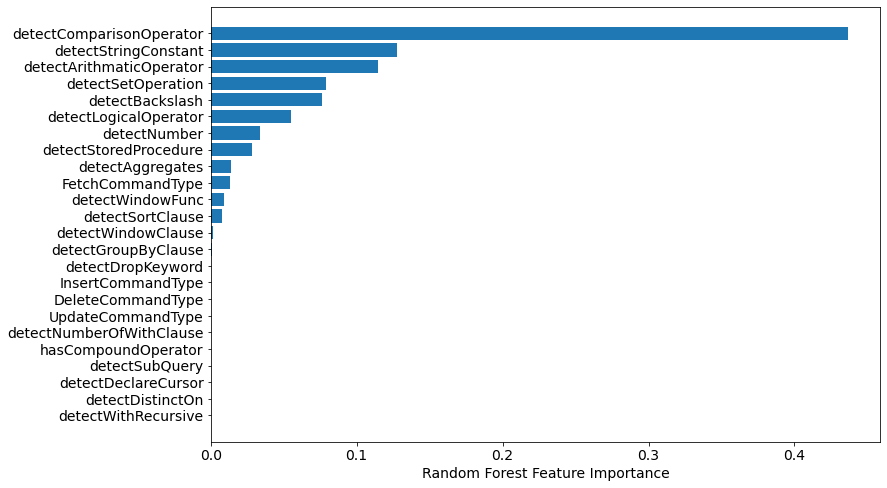

In [9]:

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

**Frequency distributions of the features(Histograms)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2574b1f90>,
      dtype=object)

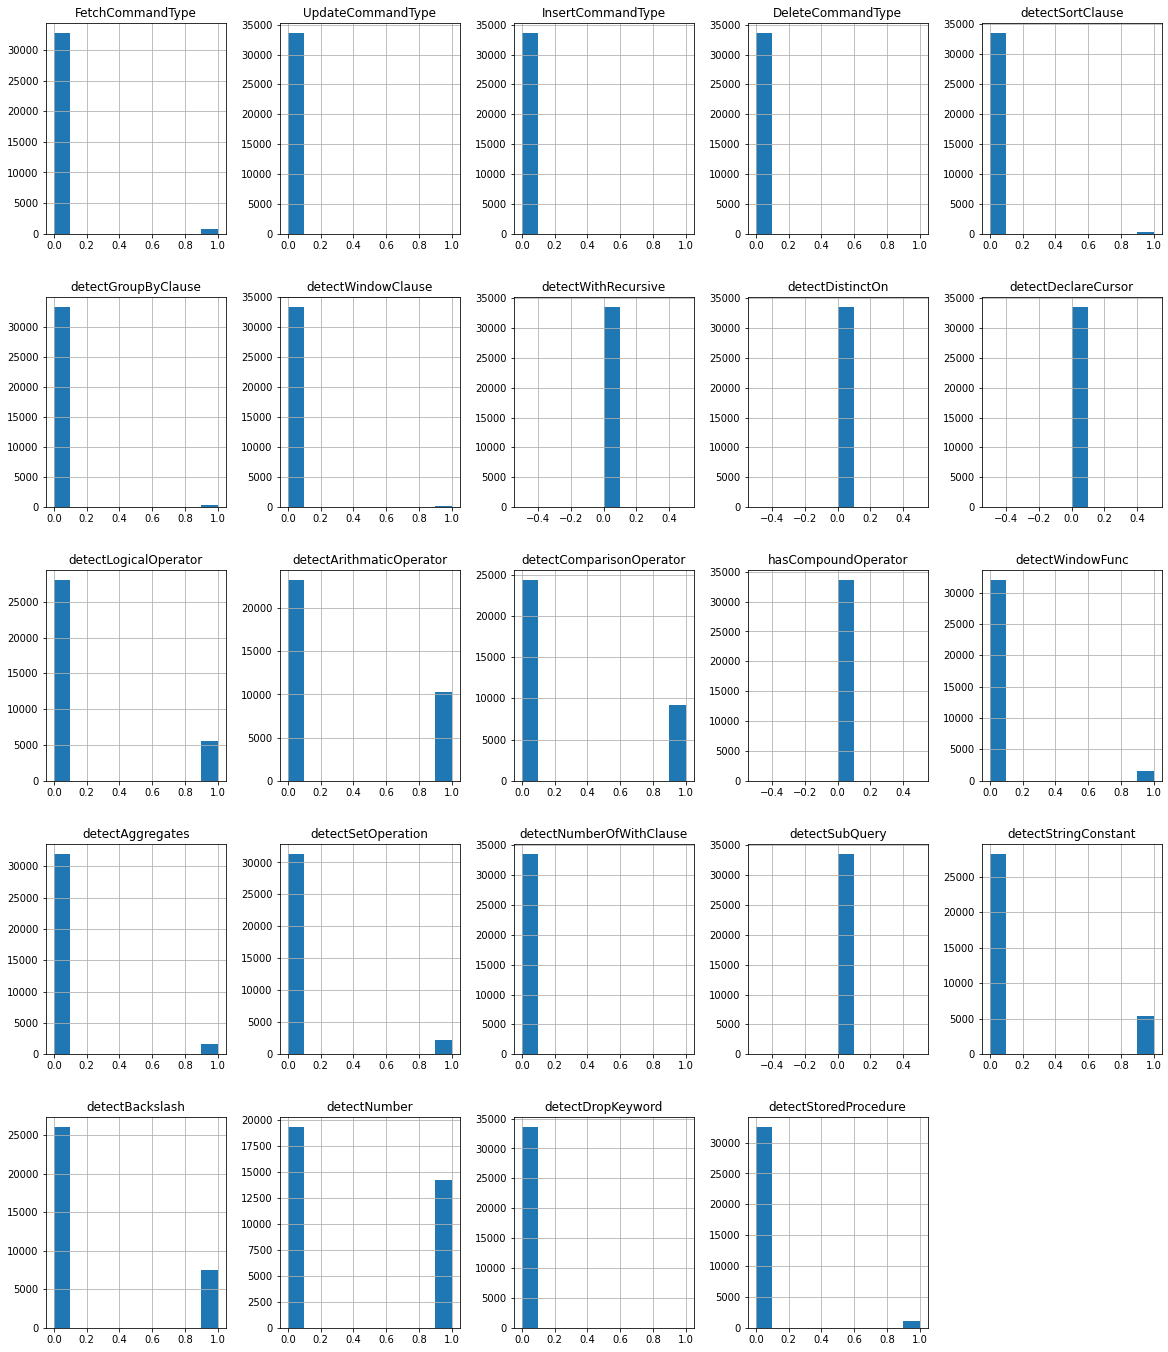

In [ ]:
X.hist( figsize=(20, 24))

## Feature selection based on mean value of the variables

we want remove those columns that have mean value = 0 or 1

In [ ]:

selected_columns=[]
for rownum,(column_name,mean) in  enumerate(feature_table.mean().items()):
    #print(column_name+"-"+str(mean))
    if(mean==0 or mean==1):
      selected_columns.append(column_name)


print(selected_columns)
X = X.drop(selected_columns,axis='columns')
X.head()


['detectWithRecursive', 'detectDistinctOn', 'detectDeclareCursor', 'hasCompoundOperator', 'detectSubQuery']


,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0


In [ ]:
column_names=[]
for col in X.columns:
    column_names.append(col)
column_names.append('Label')
column_names

['FetchCommandType',
 'UpdateCommandType',
 'InsertCommandType',
 'DeleteCommandType',
 'detectSortClause',
 'detectGroupByClause',
 'detectWindowClause',
 'detectLogicalOperator',
 'detectArithmaticOperator',
 'detectComparisonOperator',
 'detectWindowFunc',
 'detectAggregates',
 'detectSetOperation',
 'detectNumberOfWithClause',
 'detectStringConstant',
 'detectBackslash',
 'detectNumber',
 'detectDropKeyword',
 'detectStoredProcedure',
 'Label']

[Correlation Matrix](https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07)

Reference:
 
1) https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/


# Correlation matrix, covariance matrix and cosine similarity matrix

## Correlation matrix

**Remove Collinear Variables**

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.
The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9.


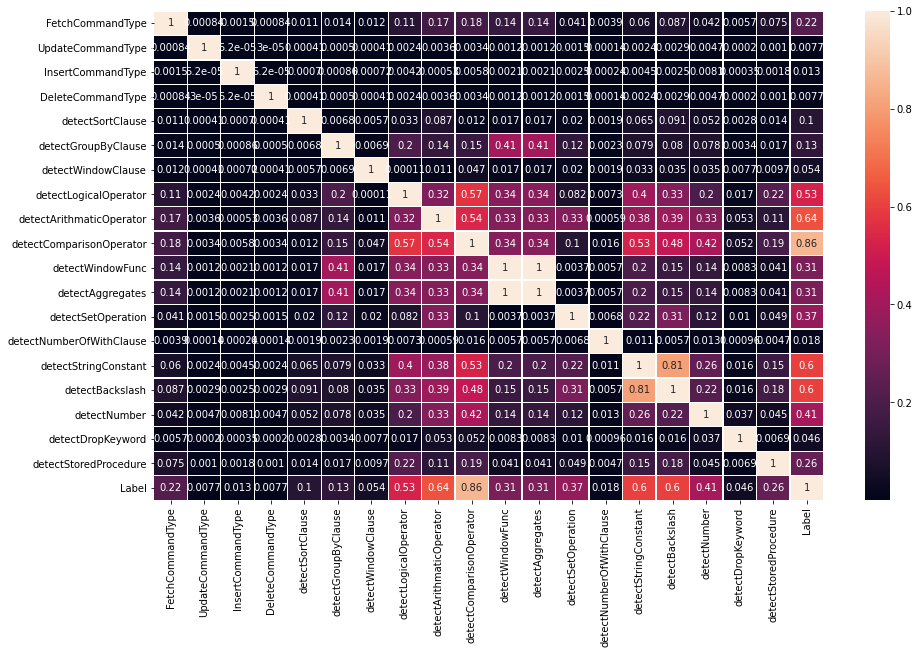

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = feature_table[column_names].corr(method ='pearson').abs()

# plot the absolute values in the heatmap
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix,annot=True,linewidth=0.3)
plt.show()

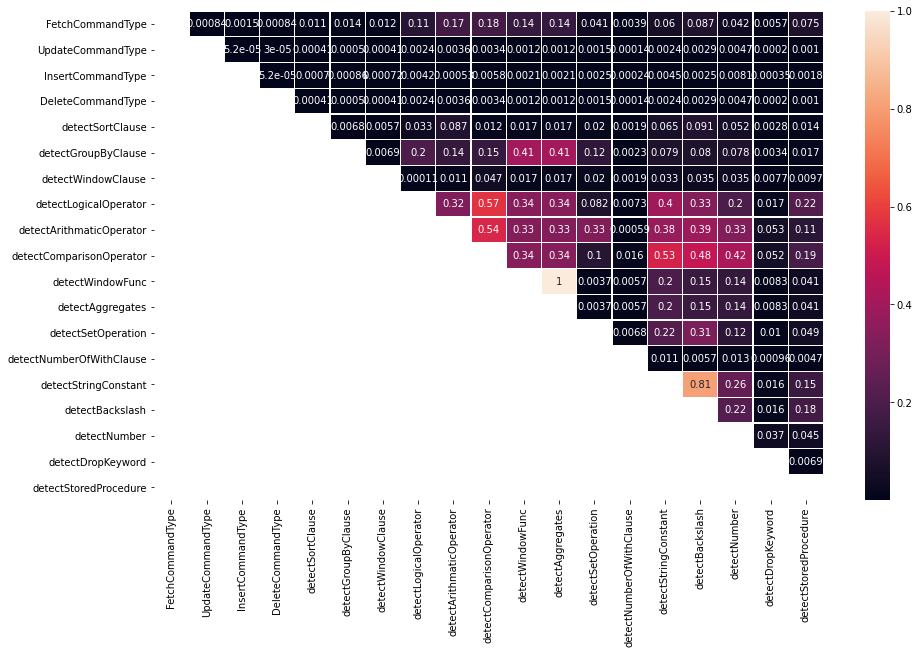

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(upper,annot=True,linewidth=0.3)
plt.show()

In [ ]:
print(upper.columns)
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
to_drop

Index(['FetchCommandType', 'UpdateCommandType', 'InsertCommandType',
       'DeleteCommandType', 'detectSortClause', 'detectGroupByClause',
       'detectWindowClause', 'detectLogicalOperator',
       'detectArithmaticOperator', 'detectComparisonOperator',
       'detectWindowFunc', 'detectAggregates', 'detectSetOperation',
       'detectNumberOfWithClause', 'detectStringConstant', 'detectBackslash',
       'detectNumber', 'detectDropKeyword', 'detectStoredProcedure'],
      dtype='object')
There are 1 columns to remove.


['detectAggregates']

In [ ]:
# drop correlated variables
X = X.drop(columns = to_drop)
X.head()

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,detectWindowFunc,detectSetOperation,detectNumberOfWithClause,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0


In [ ]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
33573    0
33574    0
33575    0
33576    0
33577    0
Name: Label, Length: 33578, dtype: int64

**Imbalanced dataset**

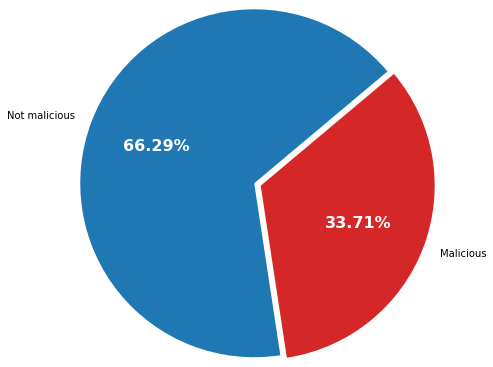

In [ ]:
explode1 = (0, 0.08)
exp_labels=["Not malicious","Malicious"]
fig1, ax1 = plt.subplots()
_, _, autopcts = ax1.pie(Y.value_counts(),explode= explode1, labels=exp_labels,autopct='%0.2f%%',radius=2,
        shadow=False,startangle=40, colors=('tab:blue', 'tab:red'))

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':16})
plt.show()

# Feature Selection using wrapper methods

## feature selection using forward selection

In [ ]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn import model_selection


cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 62 )

# Sequential Forward Selection(sfs)
sfs = SFS(AdaBoostClassifier(),
          k_features=11,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = cv_split)

sfs.fit(X, Y)
sfs.k_feature_names_ 




('FetchCommandType',
 'UpdateCommandType',
 'InsertCommandType',
 'DeleteCommandType',
 'detectSortClause',
 'detectWindowClause',
 'detectComparisonOperator',
 'detectWindowFunc',
 'detectSetOperation',
 'detectStringConstant',
 'detectStoredProcedure')

## Feature selection using Backward Elimination selection

Note: Sometimes fit() doesn't allow dataframe object.But it allows numpy array  and X.iloc[:-1]

ref: https://github.com/marcotcr/lime/issues/293

In [ ]:
#Sequential backward selection(sbs)
sbs = SFS(AdaBoostClassifier(),
         k_features=12,
         forward=False,
         floating=False,
         scoring = 'accuracy',
         cv=cv_split)


sbs.fit(X.values, Y)
sbs.k_feature_names_

('0', '1', '2', '3', '4', '5', '6', '9', '10', '11', '13', '17')

In [ ]:
sbs_features = []

features = X.columns.to_list()
for feature_num in list(sbs.k_feature_names_):
    #print(features[int(feature_num) ])
    sbs_features.append(features[int(feature_num) ])



sbs_features

['FetchCommandType',
 'UpdateCommandType',
 'InsertCommandType',
 'DeleteCommandType',
 'detectSortClause',
 'detectGroupByClause',
 'detectWindowClause',
 'detectComparisonOperator',
 'detectWindowFunc',
 'detectSetOperation',
 'detectStringConstant',
 'detectStoredProcedure']

## Feature selection using Bi-directional elimination(Step-wise Selection)

In [ ]:
sffs = SFS(AdaBoostClassifier(),
         k_features=(3,11),
         forward=True,
         floating=True,
         cv=cv_split)
sffs.fit(X.values, Y)


SequentialFeatureSelector(clone_estimator=True,
                          cv=ShuffleSplit(n_splits=10, random_state=62, test_size=0.2, train_size=0.8),
                          estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                       base_estimator=None,
                                                       learning_rate=1.0,
                                                       n_estimators=50,
                                                       random_state=None),
                          floating=True, forward=True, k_features=(3, 11),
                          n_jobs=1, pre_dispatch='2*n_jobs', scoring=None,
                          verbose=0)

In [ ]:
sffs.k_feature_names_

('0', '2', '4', '6', '9', '10', '11', '13', '17')

In [ ]:

sffs_features = []

features = X.columns.to_list()
for feature_num in list(sffs.k_feature_names_):
    #print(features[int(feature_num) ])
    sffs_features.append(features[int(feature_num) ])



sffs_features

['FetchCommandType',
 'InsertCommandType',
 'detectSortClause',
 'detectWindowClause',
 'detectComparisonOperator',
 'detectWindowFunc',
 'detectSetOperation',
 'detectStringConstant',
 'detectStoredProcedure']

**Plotting the performance of forward selection**

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

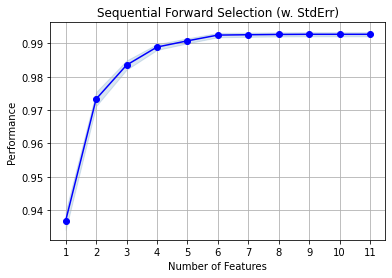

In [ ]:

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

**Plotting the performance of backward selection**

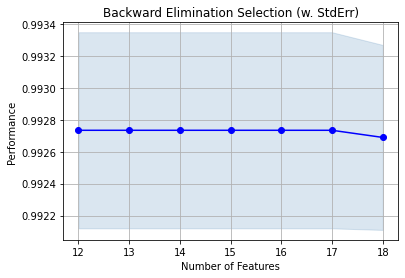

In [ ]:

fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Backward Elimination Selection (w. StdErr)')
plt.grid()
plt.show()

**Plotting the performance of Bi-directional elimination**

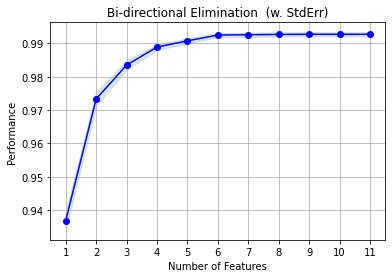

In [ ]:

fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Bi-directional Elimination  (w. StdErr)')
plt.grid()
plt.show()

Blog for wrapper feature selection: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

## Installing Pycaret and sklearn-genetic

In [ ]:
#pip install pycaret

In [ ]:
#pip install sklearn-genetic

## Feature Selection using Genetic algorithm(PyCaret)

In [ ]:
'''
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV

mcc = make_scorer(matthews_corrcoef)
estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)

from sklearn.model_selection import *
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
rkf = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 10)
for i in range(2,22):
  
    selector = GeneticSelectionCV(estimator,
                                cv = rkf,
                                verbose = 0,
                                scoring = mcc,
                                max_features = i,
                                n_population = 50,
                                crossover_proba = 0.5,
                                mutation_proba = 0.2,
                                n_generations = 10,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.05,
                                #tournament_size = 3,
                                n_gen_no_change=10,
                                caching=True,
                                n_jobs=-1)
  
    selector = selector.fit(X, Y)
    genfeats = X.columns[selector.support_]
    genfeats = list(genfeats)
    print("Chosen Feats:  ", genfeats)

cv_score = selector.generation_scores_[-1]
nofeats.append(len(genfeats)) 
chosen_feats.append(genfeats) 
cvscore.append(cv_score)





report["No of Feats"] = nofeats
report["Chosen Feats"] = chosen_feats
report["Scores"] = cvscore



'''


In [ ]:
'''
report["Scores"] = np.round(report["Scores"], 3)
report.sort_values(by = "Scores", ascending = False, inplace = False)
#report.index
ga_feats = report.iloc[0]["Chosen Feats"]

used_feats =  ga_feats.copy()
used_feats.append('ClassLabel')

print(report)
print(ga_feats)
'''

# Filter-based feature selection method :
As we have categorical(boolean) inputs and categorical(boolean) output,we are using mutual_info_classif and chi2

Reference:
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

fs = SelectKBest(score_func=mutual_info_classif, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, Y)
print(X_selected.shape)
X_selected

In [ ]:
fs = SelectKBest(score_func=chi2, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, Y)
print(X_selected.shape)
X_selected

You may be working on a regression problem and achieve zero prediction errors.

Alternately, you may be working on a classification problem and achieve 100% accuracy.

This is unusual and there are many possible reasons for this, including:

You are evaluating model performance on the training set by accident.
Your hold out dataset (train or validation) is too small or unrepresentative.
You have introduced a bug into your code and it is doing something different from what you expect.
Your prediction problem is easy or trivial and may not require machine learning.
The most common reason is that your hold out dataset is too small or not representative of the broader problem.

This can be addressed by:

Using k-fold cross-validation to estimate model performance instead of a train/test split.
Gather more data.
Use a different split of data for train and test, such as 50/50.

# Best Machine Learning Model Evaluation

## GridSearchCV hyperparameter tuning technique (Without Re-sampling technique)

In [ ]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
# Readying neural network model
def build_cnn(activation = 'relu',
              dropout_rate = 0.2,
              optimizer = 'Adam'):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),
              activation=activation,
              input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    return model

**Set the hyperparameters of all the ML model**

In [ ]:
model_params1 = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20,30,40,45,50],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },
    
}

model_params2={
    'XGBoost':{
        'model': XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=10) ,
        'params':{
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }
    },
   
}
model_params3={
     'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}
model_params4={
    
}




## training and validation curve plotting function

In [ ]:
def plot_loss_curve(clf):
    test_scores = clf.cv_results_['mean_test_score']
    train_scores = clf.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

## Training the dataset using Grid Serach approach

In [ ]:



def initGridSearch(x,y,model_params):
    scores = []

    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}
    reports={}
    for model_name, mp in model_params.items():
        grid =  GridSearchCV( mp['model'],
                             param_grid= mp['params'], 
                             cv=10,  # 10-fold cross validation
                             return_train_score=True,
                             n_jobs=-1)
        clf=grid.fit(x, y)
        # plot the training and validation curve
        plot_loss_curve(clf)
        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        reports[model_name] = report

        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']
        print("accuracy: "+str(accuracy)+" precision: "+str(macro_precision)+
              " recall:"+str(macro_recall)+" f1-score:"+str(macro_f1))

        scores.append({
            'model': model_name.upper(),
            'best_score': grid.best_score_,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,
            
        
        })
          
    return scores,reports,ConfusionMatrix
    


## Set the optimized feature list after feature selection

In [ ]:
optimized_features= ['FetchCommandType','UpdateCommandType','DeleteCommandType','InsertCommandType','detectSortClause','detectWindowClause',
                    'detectComparisonOperator','detectWindowFunc','detectSetOperation','detectStringConstant','detectGroupByClause',
                    'detectStoredProcedure']
X[optimized_features]

,FetchCommandType,UpdateCommandType,DeleteCommandType,InsertCommandType,detectSortClause,detectWindowClause,detectComparisonOperator,detectWindowFunc,detectSetOperation,detectStringConstant,detectGroupByClause,detectStoredProcedure
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
33573,0,0,0,0,0,0,0,0,0,0,0,0
33574,0,0,0,0,0,0,0,0,0,0,0,0
33575,0,0,0,0,0,0,0,0,0,0,0,0
33576,0,0,0,0,0,0,0,0,0,0,0,0


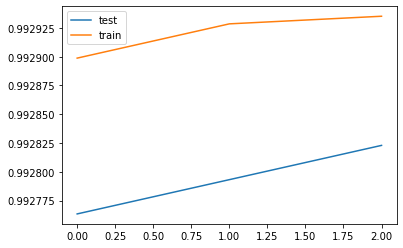

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
accuracy: 0.9929418071356245 precision: 0.9933225579329241 recall:0.9908775603610342 f1-score:0.9920844215768373


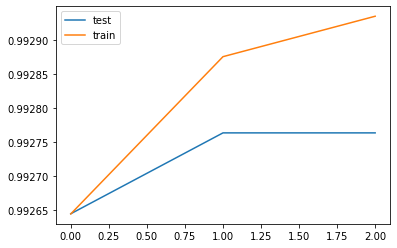

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
accuracy: 0.9928822443266424 precision: 0.9932777171150771 recall:0.9907892211384195 f1-score:0.9920172724268463


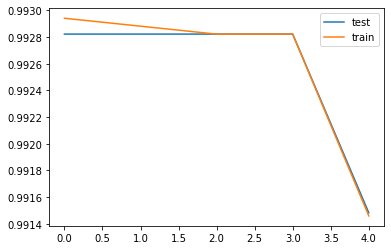

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
accuracy: 0.9929418071356245 precision: 0.9933225579329241 recall:0.9908775603610342 f1-score:0.9920844215768373


In [ ]:
scores3,reports3,confusion_matrix3=initGridSearch(X[optimized_features],Y,model_params3)


In [ ]:
df3 = pd.DataFrame(scores,columns=['model','best_score','precision','recall','f1_score','best_params'])
df3.to_csv("Report3(without_resampling).csv")
df3

,model,best_score,precision,recall,f1_score,best_params
0,RANDOM_FOREST,0.992823,0.993300,0.990833,0.992051,{'n_estimators': 1}
1,LOGISTIC_REGRESSION,0.992763,0.993278,0.990789,0.992017,{'C': 5}
2,NAIVE_BAYES:BERNOULLINB,0.992823,0.993323,0.990878,0.992084,{'alpha': 0.01}


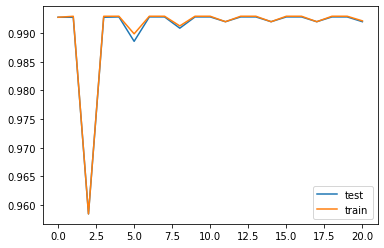

-------------------------------------------
SVM
-------------------------------------------
accuracy: 0.9929418071356245 precision: 0.9933225579329241 recall:0.9908775603610342 f1-score:0.9920844215768373


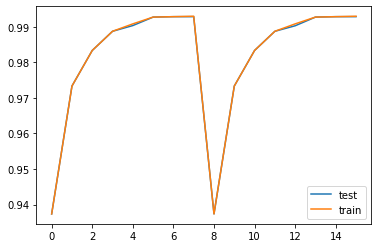

-------------------------------------------
DECISION_TREE
-------------------------------------------
accuracy: 0.9928226815176604 precision: 0.9932328840489155 recall:0.9907008819158046 f1-score:0.9919501173068532


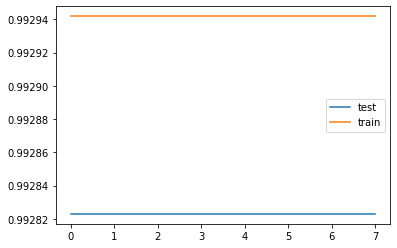

-------------------------------------------
ADABOOST
-------------------------------------------
accuracy: 0.9929418071356245 precision: 0.9933225579329241 recall:0.9908775603610342 f1-score:0.9920844215768373


In [ ]:
scores1,reports1,confusion_matrix1=initGridSearch(X[optimized_features],Y,model_params1)

In [ ]:
df1 = pd.DataFrame(scores1,columns=['model','best_score','precision','recall','f1_score','best_params'])
df1.to_csv("Report1(without_resampling).csv")
df1

,model,best_score,precision,recall,f1_score,best_params
0,SVM,0.992823,0.993323,0.990878,0.992084,"{'C': 10, 'kernel': 'linear'}"
1,DECISION_TREE,0.992823,0.993233,0.990701,0.991950,"{'criterion': 'gini', 'max_depth': 7}"
2,ADABOOST,0.992823,0.993323,0.990878,0.992084,"{'base_estimator__criterion': 'gini', 'base_es..."


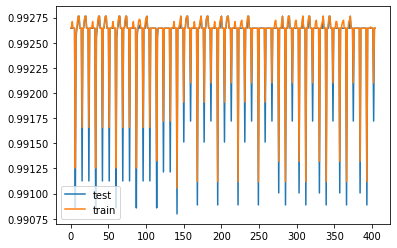

-------------------------------------------
XGBOOST
-------------------------------------------
accuracy: 0.9927631187086783 precision: 0.9931437745100298 recall:0.9906559542493476 f1-score:0.9918836702917306


In [ ]:
scores2,reports2,confusion_matrix2=initGridSearch(X[optimized_features],Y,model_params2)

In [ ]:
df2 = pd.DataFrame(scores2,columns=['model','best_score','precision','recall','f1_score','best_params'])
df2.to_csv("Report2(without_resampling).csv")
df2

,model,best_score,precision,recall,f1_score,best_params
0,XGBOOST,0.992763,0.993144,0.990656,0.991884,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d..."


## Confusion Matrix of all the Models

In [ ]:
#Confusion matrix of best classification results of the models
def plot_confusion_matrix(confusion_matrix):

    for model_name,matrix in confusion_matrix.items():
        #print(model_name)
        plt.figure(figsize = (10,7))
        sns.heatmap(matrix, annot=True)
        plt.title(model_name.upper())
        plt.xlabel('Predicted')
        plt.ylabel('Truth')



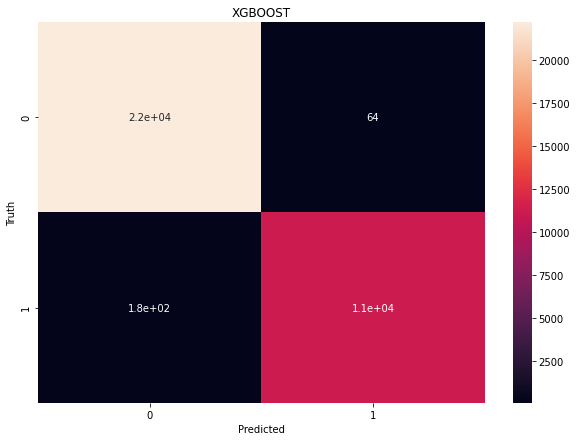

In [ ]:
plot_confusion_matrix(confusion_matrix2)

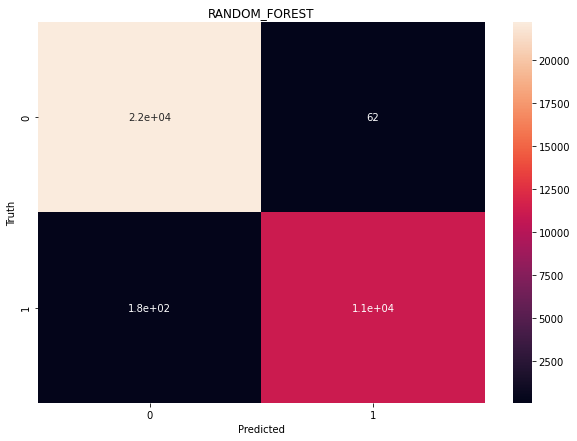

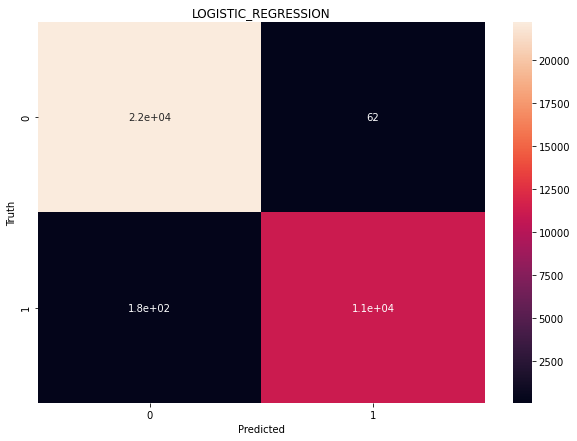

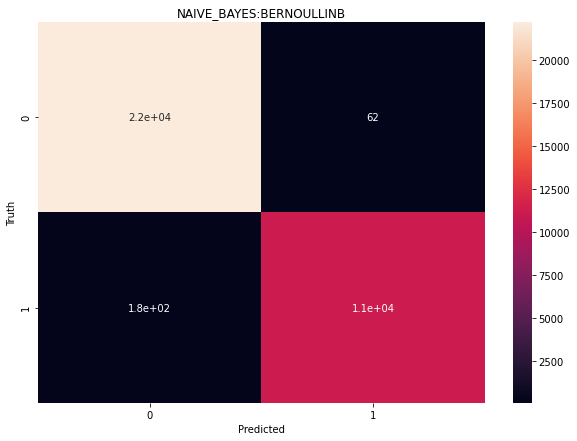

In [ ]:
plot_confusion_matrix(confusion_matrix3)

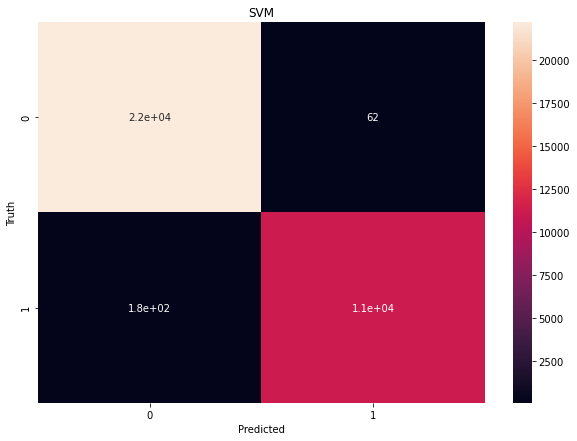

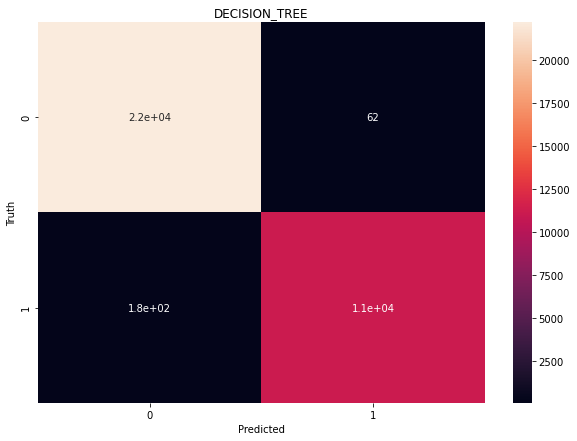

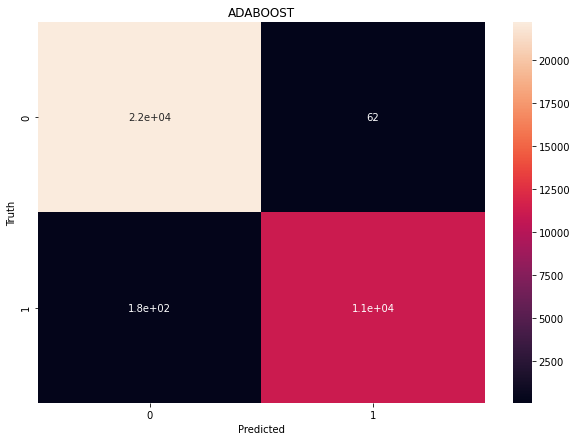

In [ ]:
plot_confusion_matrix(confusion_matrix1)

## F-measures of all the models in barplot

In [ ]:
# '7' means 7 ML models performance are going to be shown
num_of_ml_model=7
x = np.arange(num_of_ml_model)
width = 0.4
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, accuracies, width, color='cyan')
plt.bar(x, precisions, width, color='orange')
plt.bar(x+0.2, recalls, width, color='green')
plt.bar(x+0.4, f1_scores, width, color='red')

plt.xticks(x, ['SVM', 'DECISION_TREE', 'ADABOOST','XGBoost' ,'RANDOM_FOREST', 'LOGISTIC_REGRESSION','NAIVE_BAYES'])
plt.xlabel("Machine Learning Models")
plt.ylabel("F-measures")
plt.legend(["Accuracy", "Precision", "Recall","F1-score"])
plt.show()

## GridSearchCV hyperparameter tuning technique (With Re-sampling technique)

In [ ]:
from joblib import dump,load
import requests,json
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#target_model_name='Adaboost'
#target_sampling_type='SMOTEENN'

###### Object Serialization #######
## method for storing object to the file
def saveModel(model_object,model_name):
    dump(model_object,model_name+'.joblib')

# method for loading the object from the file
def loadModel(model_name):
    model_object= load(model_name)
    return model_object


# method to choose the best performing ML model for storing it to the file
def getBestClassifierObject(model_name,sampling_type,classifierObject):
   
    if(model_name==target_model_name and sampling_type==target_sampling_type):
        print('helloooooooooooooooooooooooooooooooooooooooo')
        #print(classifierObject)
        saveModel(classifierObject,model_name)


In [ ]:
def checkSavedClassifierResults():
    adaboostModel =loadModel(target_model_name+'.joblib')
    result= adaboostModel.best_estimator_.predict([[1,1,0,1,	0,	0,	0,	0,	0,	0]])
    print(result)

#checkSavedClassifierResults()

**Apply transformation to dataset**

In [ ]:
def transform(transformer,x,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,Y_resampled = transformer.fit_sample(x.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(Y_resampled)


def launch_Grid_Search_Resampling(sampling_type,x,y,model_params):
    scores = []
    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}

    for model_name, mp in model_params.items():
        grid =  GridSearchCV(estimator=mp['model'],param_grid= mp['params'],scoring='accuracy', 
                             cv=10,n_jobs=-1,verbose=2, return_train_score=True)
        clf = grid.fit(x, y)
        plot_loss_curve(clf)
        #getBestClassifierObject(model_name,sampling_type,grid)

        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        print(report)
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']

        scores.append({
            'sampling_type':sampling_type,
            'model': model_name.upper(),
            'best_score': grid.best_score_,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,    
        })      
    return scores






In [ ]:
optimized_X=X[optimized_features]

datasets = []

datasets.append(transform(SMOTE(n_jobs=-1),optimized_X,Y))
datasets.append(transform(RandomOverSampler(),optimized_X,Y))
datasets.append(transform(NearMiss(n_jobs=-1),optimized_X,Y))
datasets.append(transform(RandomUnderSampler(),optimized_X,Y))
datasets.append(transform(SMOTEENN(),optimized_X,Y))
datasets.append(transform(SMOTETomek(),optimized_X,Y))





Transforming SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Transforming RandomOverSampler
Transforming NearMiss


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming RandomUnderSampler
Transforming SMOTEENN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming SMOTETomek


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


______________________________________________________________
SMOTE
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  8.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


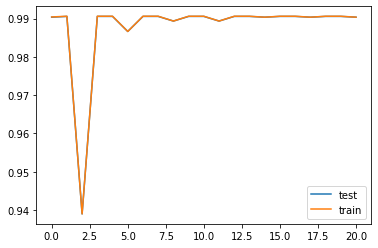

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9842142603760199, 'recall': 0.9972144846796658, 'f1-score': 0.9906717250613701, 'support': 22258}, 'Malicious': {'precision': 0.9971771990529958, 'recall': 0.9840057507413065, 'f1-score': 0.9905476911944281, 'support': 22258}, 'accuracy': 0.9906101177104861, 'macro avg': {'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}, 'weighted avg': {'precision': 0.9906957297145079, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.2s finished


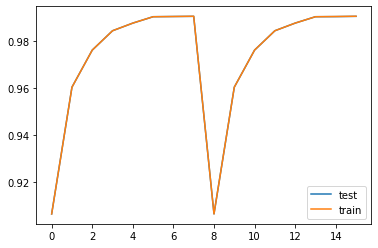

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9842142603760199, 'recall': 0.9972144846796658, 'f1-score': 0.9906717250613701, 'support': 22258}, 'Malicious': {'precision': 0.9971771990529958, 'recall': 0.9840057507413065, 'f1-score': 0.9905476911944281, 'support': 22258}, 'accuracy': 0.9906101177104861, 'macro avg': {'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}, 'weighted avg': {'precision': 0.9906957297145079, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


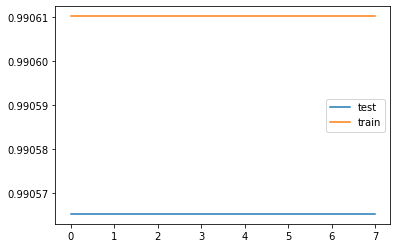

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9842142603760199, 'recall': 0.9972144846796658, 'f1-score': 0.9906717250613701, 'support': 22258}, 'Malicious': {'precision': 0.9971771990529958, 'recall': 0.9840057507413065, 'f1-score': 0.9905476911944281, 'support': 22258}, 'accuracy': 0.9906101177104861, 'macro avg': {'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}, 'weighted avg': {'precision': 0.9906957297145079, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  8.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


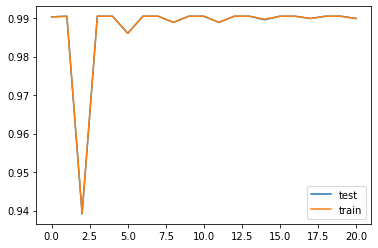

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.3s finished


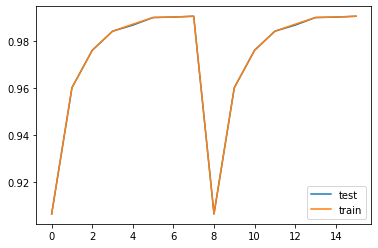

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


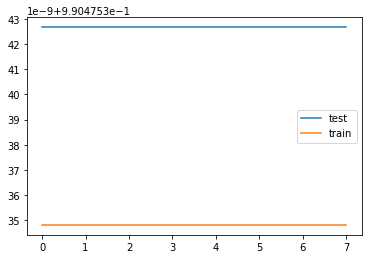

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


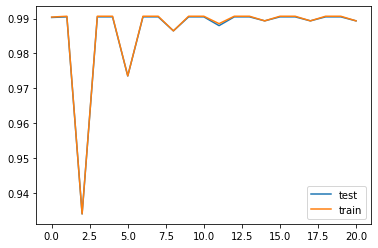

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.984728161270617, 'recall': 0.9968197879858657, 'f1-score': 0.9907370824004565, 'support': 11320}, 'Malicious': {'precision': 0.9967802522135766, 'recall': 0.9845406360424028, 'f1-score': 0.9906226389938224, 'support': 11320}, 'accuracy': 0.9906802120141343, 'macro avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}, 'weighted avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.2s finished


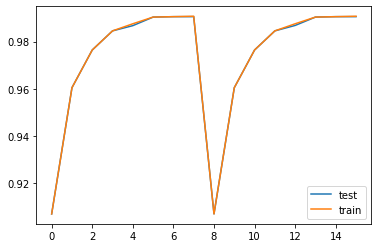

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9843845415685248, 'recall': 0.9968197879858657, 'f1-score': 0.990563139182724, 'support': 11320}, 'Malicious': {'precision': 0.9967790999373713, 'recall': 0.9841872791519435, 'f1-score': 0.9904431702004711, 'support': 11320}, 'accuracy': 0.9905035335689046, 'macro avg': {'precision': 0.9905818207529481, 'recall': 0.9905035335689045, 'f1-score': 0.9905031546915976, 'support': 22640}, 'weighted avg': {'precision': 0.9905818207529481, 'recall': 0.9905035335689046, 'f1-score': 0.9905031546915976, 'support': 22640}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


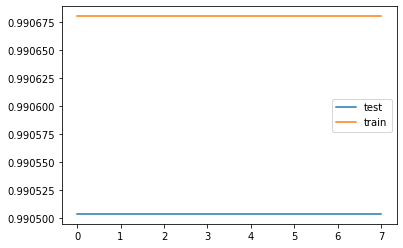

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.984728161270617, 'recall': 0.9968197879858657, 'f1-score': 0.9907370824004565, 'support': 11320}, 'Malicious': {'precision': 0.9967802522135766, 'recall': 0.9845406360424028, 'f1-score': 0.9906226389938224, 'support': 11320}, 'accuracy': 0.9906802120141343, 'macro avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}, 'weighted avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


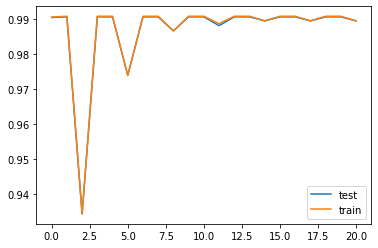

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9847348220516399, 'recall': 0.9972614840989399, 'f1-score': 0.9909585674157303, 'support': 11320}, 'Malicious': {'precision': 0.9972261989978526, 'recall': 0.9845406360424028, 'f1-score': 0.9908428165007112, 'support': 11320}, 'accuracy': 0.9909010600706714, 'macro avg': {'precision': 0.9909805105247462, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}, 'weighted avg': {'precision': 0.9909805105247461, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.3s finished


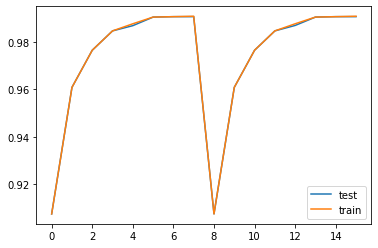

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9843913498430416, 'recall': 0.9972614840989399, 'f1-score': 0.9907846234860452, 'support': 11320}, 'Malicious': {'precision': 0.9972252058718224, 'recall': 0.9841872791519435, 'f1-score': 0.9906633469678108, 'support': 11320}, 'accuracy': 0.9907243816254417, 'macro avg': {'precision': 0.990808277857432, 'recall': 0.9907243816254416, 'f1-score': 0.9907239852269281, 'support': 22640}, 'weighted avg': {'precision': 0.9908082778574321, 'recall': 0.9907243816254417, 'f1-score': 0.990723985226928, 'support': 22640}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


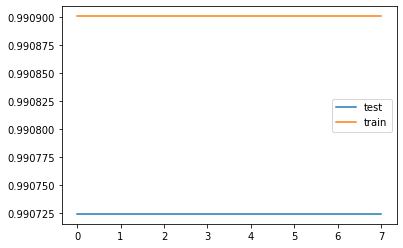

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9847348220516399, 'recall': 0.9972614840989399, 'f1-score': 0.9909585674157303, 'support': 11320}, 'Malicious': {'precision': 0.9972261989978526, 'recall': 0.9845406360424028, 'f1-score': 0.9908428165007112, 'support': 11320}, 'accuracy': 0.9909010600706714, 'macro avg': {'precision': 0.9909805105247462, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}, 'weighted avg': {'precision': 0.9909805105247461, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


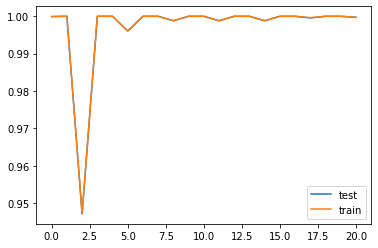

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21895}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.9s finished


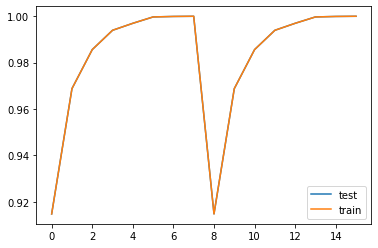

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21895}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


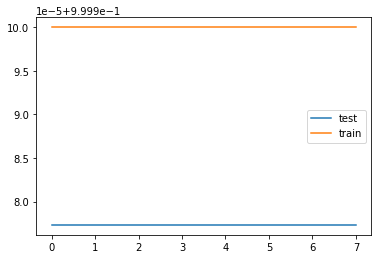

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21895}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  8.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


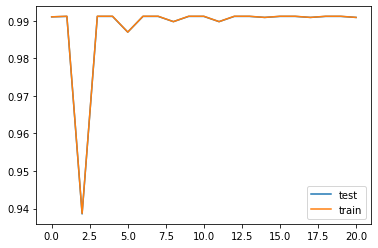

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9853940066592675, 'recall': 0.9972144846796658, 'f1-score': 0.9912690083290534, 'support': 22258}, 'Malicious': {'precision': 0.9971806648174253, 'recall': 0.9852187977356456, 'f1-score': 0.9911636421162059, 'support': 22258}, 'accuracy': 0.9912166412076556, 'macro avg': {'precision': 0.9912873357383464, 'recall': 0.9912166412076557, 'f1-score': 0.9912163252226296, 'support': 44516}, 'weighted avg': {'precision': 0.9912873357383463, 'recall': 0.9912166412076556, 'f1-score': 0.9912163252226296, 'support': 44516}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.2s finished


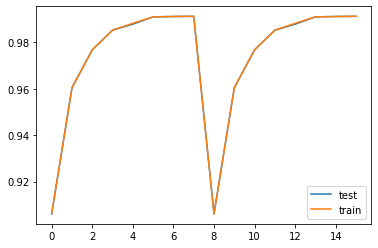

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9853940066592675, 'recall': 0.9972144846796658, 'f1-score': 0.9912690083290534, 'support': 22258}, 'Malicious': {'precision': 0.9971806648174253, 'recall': 0.9852187977356456, 'f1-score': 0.9911636421162059, 'support': 22258}, 'accuracy': 0.9912166412076556, 'macro avg': {'precision': 0.9912873357383464, 'recall': 0.9912166412076557, 'f1-score': 0.9912163252226296, 'support': 44516}, 'weighted avg': {'precision': 0.9912873357383463, 'recall': 0.9912166412076556, 'f1-score': 0.9912163252226296, 'support': 44516}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


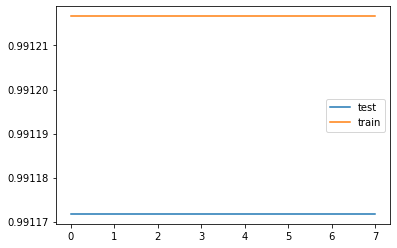

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9853940066592675, 'recall': 0.9972144846796658, 'f1-score': 0.9912690083290534, 'support': 22258}, 'Malicious': {'precision': 0.9971806648174253, 'recall': 0.9852187977356456, 'f1-score': 0.9911636421162059, 'support': 22258}, 'accuracy': 0.9912166412076556, 'macro avg': {'precision': 0.9912873357383464, 'recall': 0.9912166412076557, 'f1-score': 0.9912163252226296, 'support': 44516}, 'weighted avg': {'precision': 0.9912873357383463, 'recall': 0.9912166412076556, 'f1-score': 0.9912163252226296, 'support': 44516}}
______________________________________________________________


In [ ]:
benchmark_scores1 = []
for sample_type,x,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores1 = benchmark_scores1 + (launch_Grid_Search_Resampling(sample_type,x,y,model_params1))
    print('______________________________________________________________')



In [ ]:
print(benchmark_scores1)
sampling_results = pd.DataFrame(benchmark_scores1,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report1(with_resampling).csv")
sampling_results

[{'sampling_type': 'SMOTE', 'model': 'SVM', 'best_score': 0.9905652101156186, 'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1_score': 0.9906097081278991, 'best_params': {'C': 1, 'kernel': 'linear'}}, {'sampling_type': 'SMOTE', 'model': 'DECISION_TREE', 'best_score': 0.9905652101156186, 'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1_score': 0.9906097081278991, 'best_params': {'criterion': 'gini', 'max_depth': None}}, {'sampling_type': 'SMOTE', 'model': 'ADABOOST', 'best_score': 0.9905652101156186, 'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1_score': 0.9906097081278991, 'best_params': {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 1}}, {'sampling_type': 'RandomOverSampler', 'model': 'SVM', 'best_score': 0.9904753426701006, 'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1_score': 0.9904749021179142, 'best_params': {'C': 1, 'kernel': 'linear'}}, {'sampling_type': 'Rando

,sampling_type,model,best_score,precision,recall,f1_score,best_params
0,SMOTE,SVM,0.990565,0.990696,0.990610,0.990610,"{'C': 1, 'kernel': 'linear'}"
1,SMOTE,DECISION_TREE,0.990565,0.990696,0.990610,0.990610,"{'criterion': 'gini', 'max_depth': None}"
2,SMOTE,ADABOOST,0.990565,0.990696,0.990610,0.990610,"{'base_estimator__criterion': 'gini', 'base_es..."
3,RandomOverSampler,SVM,0.990475,0.990564,0.990475,0.990475,"{'C': 1, 'kernel': 'linear'}"
4,RandomOverSampler,DECISION_TREE,0.990475,0.990564,0.990475,0.990475,"{'criterion': 'gini', 'max_depth': None}"
5,RandomOverSampler,ADABOOST,0.990475,0.990564,0.990475,0.990475,"{'base_estimator__criterion': 'gini', 'base_es..."
6,NearMiss,SVM,0.990504,0.990754,0.990680,0.990680,"{'C': 1, 'kernel': 'linear'}"
7,NearMiss,DECISION_TREE,0.990504,0.990582,0.990504,0.990503,"{'criterion': 'gini', 'max_depth': 7}"
8,NearMiss,ADABOOST,0.990504,0.990754,0.990680,0.990680,"{'base_estimator__criterion': 'gini', 'base_es..."
9,RandomUnderSampler,SVM,0.990724,0.990981,0.990901,0.990901,"{'C': 1, 'kernel': 'linear'}"


______________________________________________________________
SMOTE
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


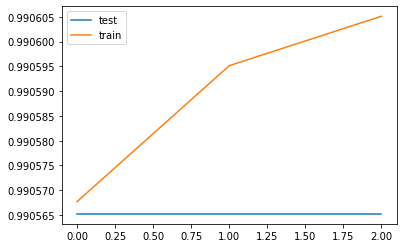

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9841706203165876, 'recall': 0.9972144846796658, 'f1-score': 0.990649617281471, 'support': 22258}, 'Malicious': {'precision': 0.9971770705277057, 'recall': 0.9839608230748494, 'f1-score': 0.9905248637525158, 'support': 22258}, 'accuracy': 0.9905876538772577, 'macro avg': {'precision': 0.9906738454221466, 'recall': 0.9905876538772576, 'f1-score': 0.9905872405169934, 'support': 44516}, 'weighted avg': {'precision': 0.9906738454221468, 'recall': 0.9905876538772577, 'f1-score': 0.9905872405169934, 'support': 44516}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


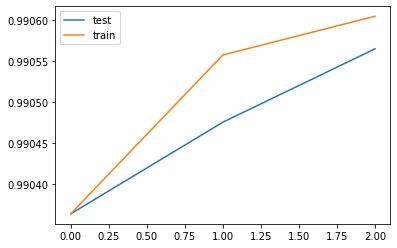

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9842142603760199, 'recall': 0.9972144846796658, 'f1-score': 0.9906717250613701, 'support': 22258}, 'Malicious': {'precision': 0.9971771990529958, 'recall': 0.9840057507413065, 'f1-score': 0.9905476911944281, 'support': 22258}, 'accuracy': 0.9906101177104861, 'macro avg': {'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}, 'weighted avg': {'precision': 0.9906957297145079, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


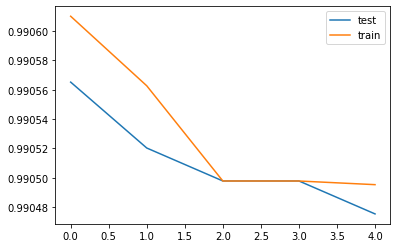

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9842142603760199, 'recall': 0.9972144846796658, 'f1-score': 0.9906717250613701, 'support': 22258}, 'Malicious': {'precision': 0.9971771990529958, 'recall': 0.9840057507413065, 'f1-score': 0.9905476911944281, 'support': 22258}, 'accuracy': 0.9906101177104861, 'macro avg': {'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}, 'weighted avg': {'precision': 0.9906957297145079, 'recall': 0.9906101177104861, 'f1-score': 0.9906097081278991, 'support': 44516}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


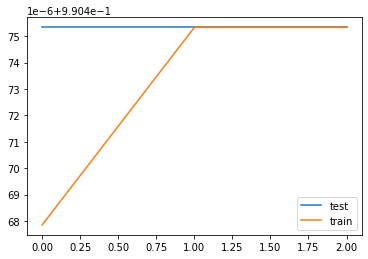

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


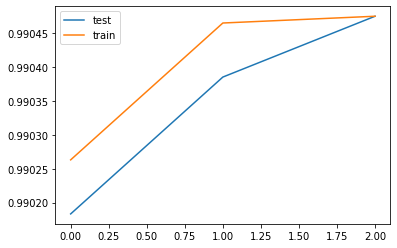

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


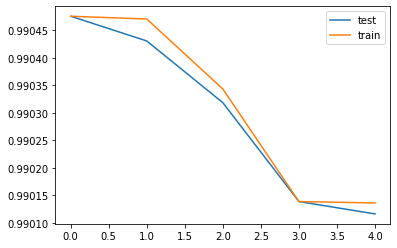

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9839524780565653, 'recall': 0.9972144846796658, 'f1-score': 0.9905390931810067, 'support': 22258}, 'Malicious': {'precision': 0.9971764277256581, 'recall': 0.9837361847425645, 'f1-score': 0.9904107110548218, 'support': 22258}, 'accuracy': 0.9904753347111152, 'macro avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179142, 'support': 44516}, 'weighted avg': {'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1-score': 0.9904749021179143, 'support': 44516}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


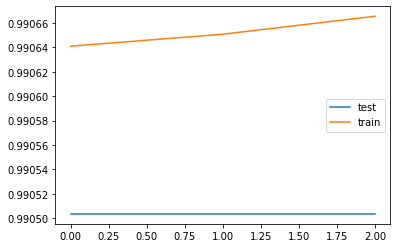

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9846422338568935, 'recall': 0.9968197879858657, 'f1-score': 0.9906935908691834, 'support': 11320}, 'Malicious': {'precision': 0.9967799642218247, 'recall': 0.984452296819788, 'f1-score': 0.9905777777777777, 'support': 11320}, 'accuracy': 0.9906360424028269, 'macro avg': {'precision': 0.990711099039359, 'recall': 0.9906360424028269, 'f1-score': 0.9906356843234805, 'support': 22640}, 'weighted avg': {'precision': 0.9907110990393592, 'recall': 0.9906360424028269, 'f1-score': 0.9906356843234805, 'support': 22640}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


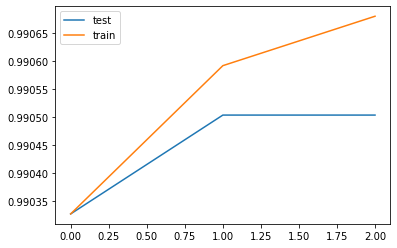

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9845563214379199, 'recall': 0.9968197879858657, 'f1-score': 0.9906501031561389, 'support': 11320}, 'Malicious': {'precision': 0.996779676178549, 'recall': 0.9843639575971731, 'f1-score': 0.9905329125738922, 'support': 11320}, 'accuracy': 0.9905918727915194, 'macro avg': {'precision': 0.9906679988082345, 'recall': 0.9905918727915194, 'f1-score': 0.9905915078650156, 'support': 22640}, 'weighted avg': {'precision': 0.9906679988082344, 'recall': 0.9905918727915194, 'f1-score': 0.9905915078650156, 'support': 22640}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


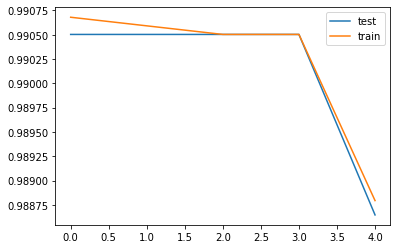

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.984728161270617, 'recall': 0.9968197879858657, 'f1-score': 0.9907370824004565, 'support': 11320}, 'Malicious': {'precision': 0.9967802522135766, 'recall': 0.9845406360424028, 'f1-score': 0.9906226389938224, 'support': 11320}, 'accuracy': 0.9906802120141343, 'macro avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}, 'weighted avg': {'precision': 0.9907542067420968, 'recall': 0.9906802120141343, 'f1-score': 0.9906798606971394, 'support': 22640}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


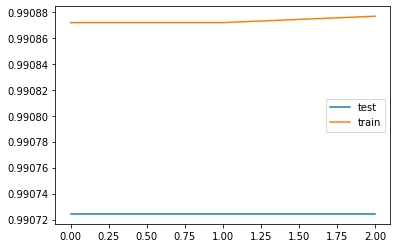

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9846489315307457, 'recall': 0.9972614840989399, 'f1-score': 0.9909150757077024, 'support': 11320}, 'Malicious': {'precision': 0.9972259507829978, 'recall': 0.984452296819788, 'f1-score': 0.9907979551011336, 'support': 11320}, 'accuracy': 0.990856890459364, 'macro avg': {'precision': 0.9909374411568718, 'recall': 0.990856890459364, 'f1-score': 0.990856515404418, 'support': 22640}, 'weighted avg': {'precision': 0.9909374411568718, 'recall': 0.990856890459364, 'f1-score': 0.9908565154044179, 'support': 22640}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


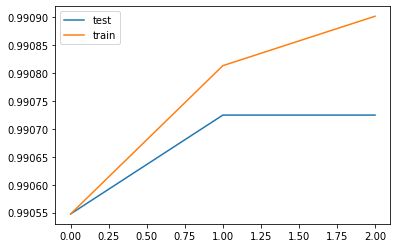

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9845630559916274, 'recall': 0.9972614840989399, 'f1-score': 0.9908715878170806, 'support': 11320}, 'Malicious': {'precision': 0.9972257025237158, 'recall': 0.9843639575971731, 'f1-score': 0.9907530897128123, 'support': 11320}, 'accuracy': 0.9908127208480565, 'macro avg': {'precision': 0.9908943792576717, 'recall': 0.9908127208480565, 'f1-score': 0.9908123387649465, 'support': 22640}, 'weighted avg': {'precision': 0.9908943792576715, 'recall': 0.9908127208480565, 'f1-score': 0.9908123387649465, 'support': 22640}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


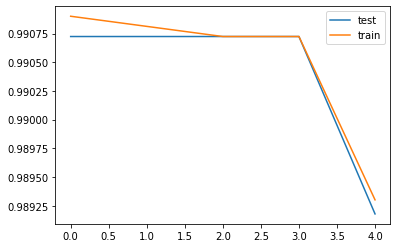

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9847348220516399, 'recall': 0.9972614840989399, 'f1-score': 0.9909585674157303, 'support': 11320}, 'Malicious': {'precision': 0.9972261989978526, 'recall': 0.9845406360424028, 'f1-score': 0.9908428165007112, 'support': 11320}, 'accuracy': 0.9909010600706714, 'macro avg': {'precision': 0.9909805105247462, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}, 'weighted avg': {'precision': 0.9909805105247461, 'recall': 0.9909010600706714, 'f1-score': 0.9909006919582207, 'support': 22640}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


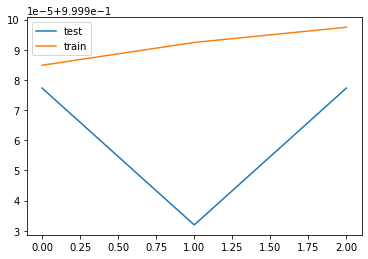

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21895}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


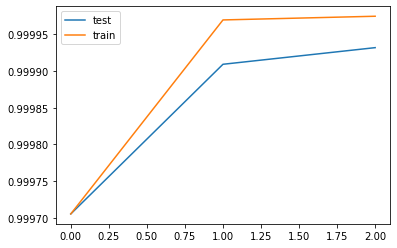

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.999954944807389, 'recall': 1.0, 'f1-score': 0.9999774718961905, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 0.9999543274720256, 'f1-score': 0.9999771632145059, 'support': 21895}, 'accuracy': 0.9999773186055478, 'macro avg': {'precision': 0.9999774724036945, 'recall': 0.9999771637360129, 'f1-score': 0.9999773175553481, 'support': 44089}, 'weighted avg': {'precision': 0.9999773196274624, 'recall': 0.9999773186055478, 'f1-score': 0.9999773186020473, 'support': 44089}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


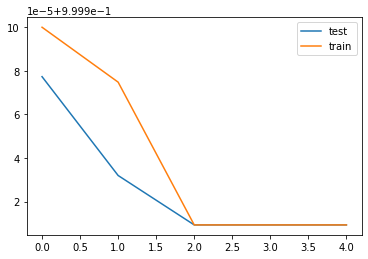

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22194}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21895}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44089}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


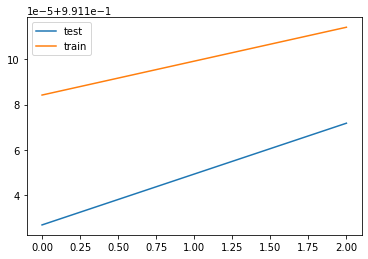

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9853502619195597, 'recall': 0.9972144846796658, 'f1-score': 0.9912468738835298, 'support': 22258}, 'Malicious': {'precision': 0.9971805366075489, 'recall': 0.9851738700691886, 'f1-score': 0.9911408425239558, 'support': 22258}, 'accuracy': 0.9911941773744272, 'macro avg': {'precision': 0.9912653992635543, 'recall': 0.9911941773744272, 'f1-score': 0.9911938582037428, 'support': 44516}, 'weighted avg': {'precision': 0.9912653992635543, 'recall': 0.9911941773744272, 'f1-score': 0.9911938582037428, 'support': 44516}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


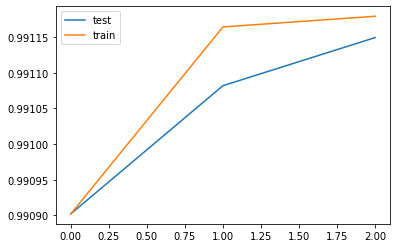

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9853065210636126, 'recall': 0.9972144846796658, 'f1-score': 0.991224740426482, 'support': 22258}, 'Malicious': {'precision': 0.9971804083860112, 'recall': 0.9851289424027316, 'f1-score': 0.9911180419011459, 'support': 22258}, 'accuracy': 0.9911717135411987, 'macro avg': {'precision': 0.9912434647248118, 'recall': 0.9911717135411987, 'f1-score': 0.991171391163814, 'support': 44516}, 'weighted avg': {'precision': 0.9912434647248118, 'recall': 0.9911717135411987, 'f1-score': 0.991171391163814, 'support': 44516}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


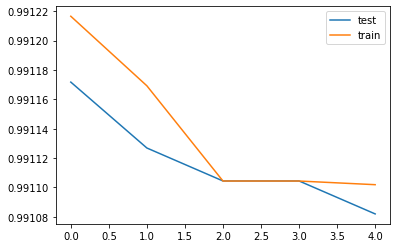

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9853940066592675, 'recall': 0.9972144846796658, 'f1-score': 0.9912690083290534, 'support': 22258}, 'Malicious': {'precision': 0.9971806648174253, 'recall': 0.9852187977356456, 'f1-score': 0.9911636421162059, 'support': 22258}, 'accuracy': 0.9912166412076556, 'macro avg': {'precision': 0.9912873357383464, 'recall': 0.9912166412076557, 'f1-score': 0.9912163252226296, 'support': 44516}, 'weighted avg': {'precision': 0.9912873357383463, 'recall': 0.9912166412076556, 'f1-score': 0.9912163252226296, 'support': 44516}}
______________________________________________________________


In [ ]:
benchmark_scores3 = []
for sample_type,x,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores3 = benchmark_scores3 + (launch_Grid_Search_Resampling(sample_type,x,y,model_params3))
    print('______________________________________________________________')



In [ ]:
print(benchmark_scores3)
sampling_results = pd.DataFrame(benchmark_scores3,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report3(with_resampling).csv")
sampling_results

[{'sampling_type': 'SMOTE', 'model': 'RANDOM_FOREST', 'best_score': 0.9905652101156186, 'precision': 0.9906738454221466, 'recall': 0.9905876538772576, 'f1_score': 0.9905872405169934, 'best_params': {'n_estimators': 1}}, {'sampling_type': 'SMOTE', 'model': 'LOGISTIC_REGRESSION', 'best_score': 0.9905652101156186, 'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1_score': 0.9906097081278991, 'best_params': {'C': 10}}, {'sampling_type': 'SMOTE', 'model': 'NAIVE_BAYES:BERNOULLINB', 'best_score': 0.9905652101156186, 'precision': 0.9906957297145078, 'recall': 0.9906101177104861, 'f1_score': 0.9906097081278991, 'best_params': {'alpha': 0.01}}, {'sampling_type': 'RandomOverSampler', 'model': 'RANDOM_FOREST', 'best_score': 0.9904753426701006, 'precision': 0.9905644528911117, 'recall': 0.9904753347111152, 'f1_score': 0.9904749021179142, 'best_params': {'n_estimators': 1}}, {'sampling_type': 'RandomOverSampler', 'model': 'LOGISTIC_REGRESSION', 'best_score': 0.9904753426701006, 'pre

,sampling_type,model,best_score,precision,recall,f1_score,best_params
0,SMOTE,RANDOM_FOREST,0.990565,0.990674,0.990588,0.990587,{'n_estimators': 1}
1,SMOTE,LOGISTIC_REGRESSION,0.990565,0.990696,0.990610,0.990610,{'C': 10}
2,SMOTE,NAIVE_BAYES:BERNOULLINB,0.990565,0.990696,0.990610,0.990610,{'alpha': 0.01}
3,RandomOverSampler,RANDOM_FOREST,0.990475,0.990564,0.990475,0.990475,{'n_estimators': 1}
4,RandomOverSampler,LOGISTIC_REGRESSION,0.990475,0.990564,0.990475,0.990475,{'C': 10}
5,RandomOverSampler,NAIVE_BAYES:BERNOULLINB,0.990475,0.990564,0.990475,0.990475,{'alpha': 0.01}
6,NearMiss,RANDOM_FOREST,0.990504,0.990711,0.990636,0.990636,{'n_estimators': 1}
7,NearMiss,LOGISTIC_REGRESSION,0.990504,0.990668,0.990592,0.990592,{'C': 5}
8,NearMiss,NAIVE_BAYES:BERNOULLINB,0.990504,0.990754,0.990680,0.990680,{'alpha': 0.01}
9,RandomUnderSampler,RANDOM_FOREST,0.990724,0.990937,0.990857,0.990857,{'n_estimators': 1}


In [ ]:
benchmark_scores2 = []
for sample_type,x,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores2 = benchmark_scores2 + (launch_Grid_Search_Resampling(sample_type,x,y,model_params2))
    print('______________________________________________________________')



______________________________________________________________
SMOTE
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 88.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 140.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 202.4min


In [ ]:
print(benchmark_scores2)
sampling_results = pd.DataFrame(benchmark_scores2,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report2(with_resampling).csv")
sampling_results